In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
# load datasets
benchmark = pd.read_csv("Benchmark.csv")
load_history_raw = pd.read_csv("Load_history.csv")
temperature_history_raw = pd.read_csv("temperature_history.csv")
test_data = pd.read_csv("test.csv")
weights = pd.read_csv("weights.csv")

# Exploratory Data Analysis

## File 1: "Load_history.csv"

### Step 1: cleaning/reformatting

In [3]:
load_history_raw.columns

Index(['zone_id', 'year', 'month', 'day', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6',
       'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16',
       'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24'],
      dtype='object')

In [4]:
# check for null values & data types
load_history_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 28 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   zone_id  33000 non-null  int64 
 1   year     33000 non-null  int64 
 2   month    33000 non-null  int64 
 3   day      33000 non-null  int64 
 4   h1       31740 non-null  object
 5   h2       31740 non-null  object
 6   h3       31740 non-null  object
 7   h4       31740 non-null  object
 8   h5       31740 non-null  object
 9   h6       31740 non-null  object
 10  h7       31720 non-null  object
 11  h8       31720 non-null  object
 12  h9       31720 non-null  object
 13  h10      31720 non-null  object
 14  h11      31720 non-null  object
 15  h12      31720 non-null  object
 16  h13      31720 non-null  object
 17  h14      31720 non-null  object
 18  h15      31720 non-null  object
 19  h16      31720 non-null  object
 20  h17      31720 non-null  object
 21  h18      31720 non-null  object
 22

In [5]:
# unclear why the hourly columns are stored as objects instead of numbers
# looking at the first few rows should give a better idea
load_history_raw.head

<bound method NDFrame.head of        zone_id  year  month  day      h1      h2      h3      h4      h5  \
0            1  2004      1    1  16,853  16,450  16,517  16,873  17,064   
1            1  2004      1    2  14,155  14,038  14,019  14,489  14,920   
2            1  2004      1    3  14,439  14,272  14,109  14,081  14,775   
3            1  2004      1    4  11,273  10,415   9,943   9,859   9,881   
4            1  2004      1    5  10,750  10,321  10,107  10,065  10,419   
...        ...   ...    ...  ...     ...     ...     ...     ...     ...   
32995       20  2008      7    3     NaN     NaN     NaN     NaN     NaN   
32996       20  2008      7    4     NaN     NaN     NaN     NaN     NaN   
32997       20  2008      7    5     NaN     NaN     NaN     NaN     NaN   
32998       20  2008      7    6     NaN     NaN     NaN     NaN     NaN   
32999       20  2008      7    7     NaN     NaN     NaN     NaN     NaN   

           h6  ...     h15     h16     h17     h18     h1

In [6]:
# maybe they're mixed data type columns?
print(load_history_raw['h1'].apply(type).value_counts())
# check for null values while we're at it
print(load_history_raw['h1'].isnull().sum())

h1
<class 'str'>      31740
<class 'float'>     1260
Name: count, dtype: int64
1260


In [7]:
# there's our problem, the null values are floats but the actual numbers are strings! lets fix that

# define a new dataframe to hold the cleaned data
load_hist = pd.DataFrame()

# the zone_id column can be loaded in as-is
load_hist['zone_id'] = load_history_raw['zone_id']

# the year, month, day columns can be collapsed into one 'date' column
load_hist['date'] = pd.to_datetime(load_history_raw[['year', 'month', 'day']])

In [8]:
# clean and load hourly columns
for col in load_history_raw.columns[4:]:
    load_hist[col] = (
        load_history_raw[col]
        .replace(',', '', regex=True)                             # remove commas
        .apply(lambda x: x.strip() if isinstance(x, str) else x)  # strip any whitespace
        .apply(pd.to_numeric, errors='coerce')                    # convert to numeric (keeping NaNs)
    )

In [9]:
hour_cols = load_hist.columns[2:]

load_hist['day_mean_load'] = load_hist[hour_cols].mean(axis=1)
load_hist['day_total_load'] = load_hist[hour_cols].sum(axis=1)

In [10]:
# check the dtypes on the new df just in case
# note that we're using floats because they can handle NaNs (ints cannot for some reason)
load_hist.dtypes

zone_id                    int64
date              datetime64[ns]
h1                       float64
h2                       float64
h3                       float64
h4                       float64
h5                       float64
h6                       float64
h7                       float64
h8                       float64
h9                       float64
h10                      float64
h11                      float64
h12                      float64
h13                      float64
h14                      float64
h15                      float64
h16                      float64
h17                      float64
h18                      float64
h19                      float64
h20                      float64
h21                      float64
h22                      float64
h23                      float64
h24                      float64
day_mean_load            float64
day_total_load           float64
dtype: object

In [11]:
# lastly, lets group by zone_id
load_hist_g = load_hist.groupby(load_hist['zone_id'])

### Step 2: Exploratory data analysis

In [12]:
# make pd show all columns
pd.set_option('display.max_columns', None)

# describe the data
load_hist_g.describe()

date                                                                 \
        count                 mean                  min                  25%   
zone_id                                                                        
1        1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   
2        1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   
3        1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   
4        1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   
5        1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   
6        1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   
7        1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   
8        1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   
9        1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   
10       1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   
11       1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   
12       1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   
13       1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   
14       1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   
15       1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   
16       1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   
17       1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   
18       1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   
19       1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   
20       1650  2006-04-04 12:00:00  2004-01-01 00:00:00  2005-02-16 06:00:00   

                                                                             \
                         50%                  75%                  max  std   
zone_id                                                                       
1        2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   
2        2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   
3        2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   
4        2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   
5        2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   
6        2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   
7        2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   
8        2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   
9        2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   
10       2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   
11       2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   
12       2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   
13       2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   
14       2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   
15       2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   
16       2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   
17       2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   
18       2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   
19       2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   
20       2006-04-04 12:00:00  2007-05-21 18:00:00  2008-07-07 00:00:00  NaN   

             h1                                                         \
          count           mean       min       25%       50%       75%   
zone_id                                                                  
1        1587.0   15565.262760    8078.0   11931.5   14544.0   18010.5   
2        1587.0  148668.462508   86128.0  128785.5  14

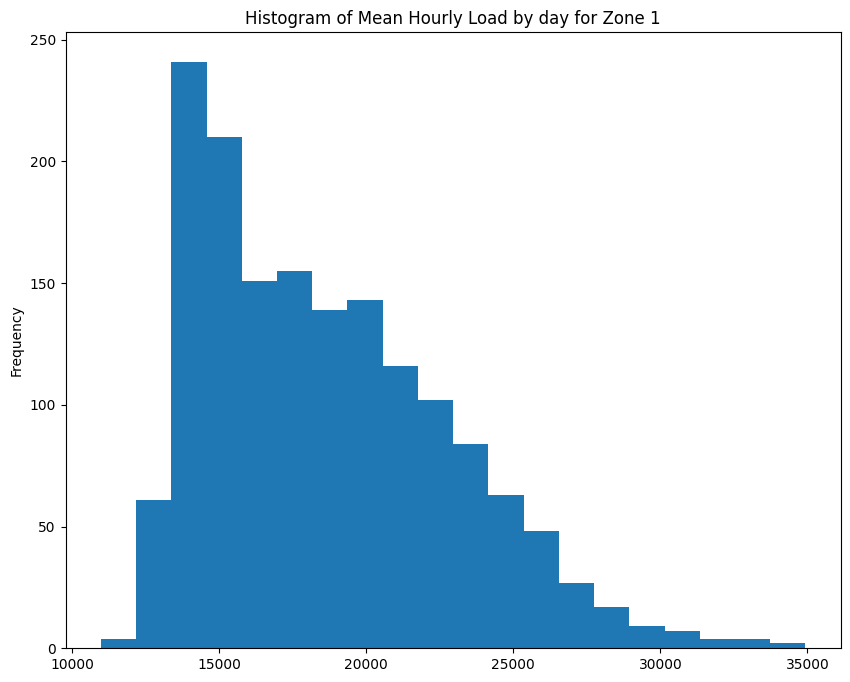

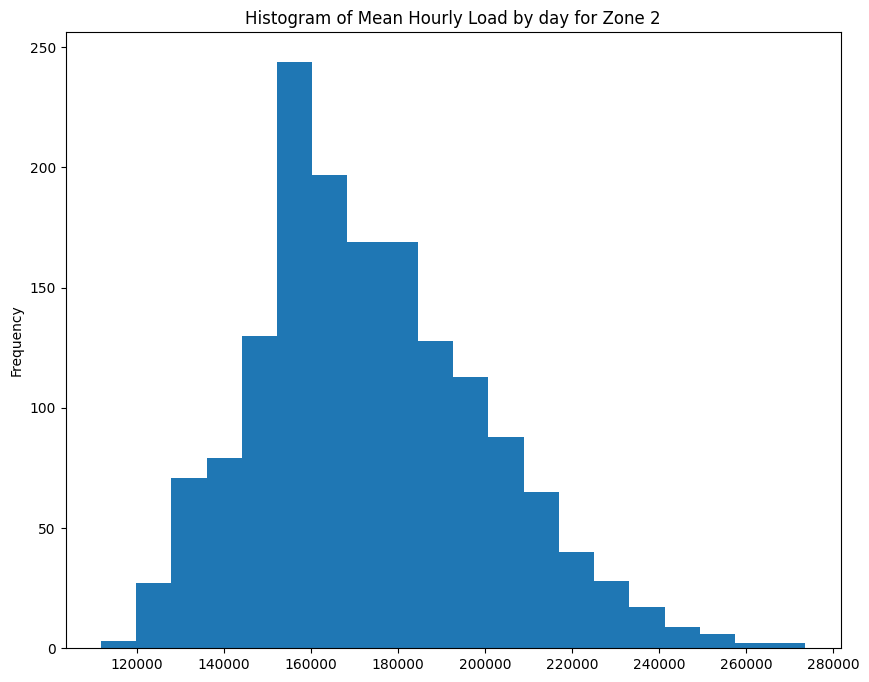

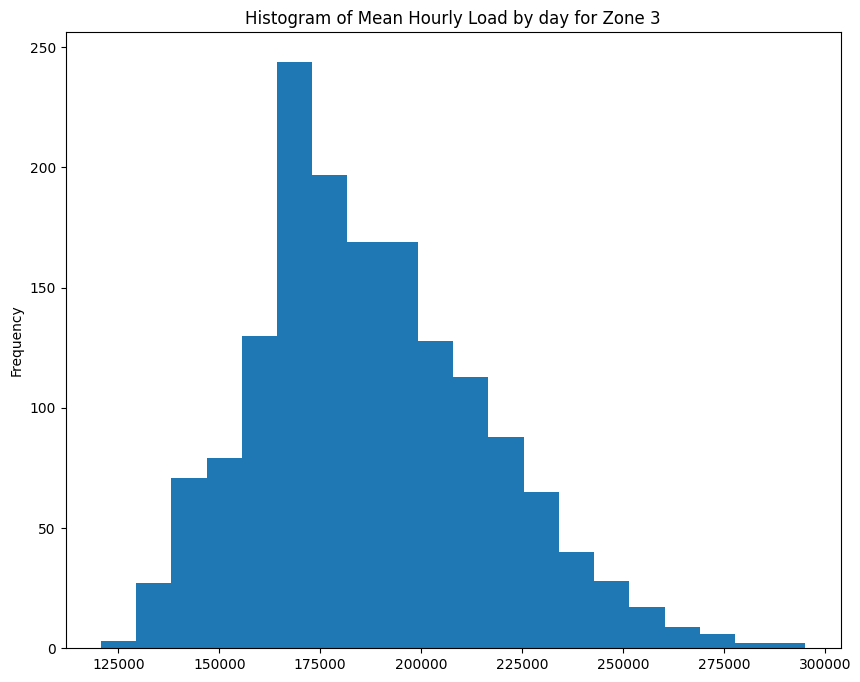

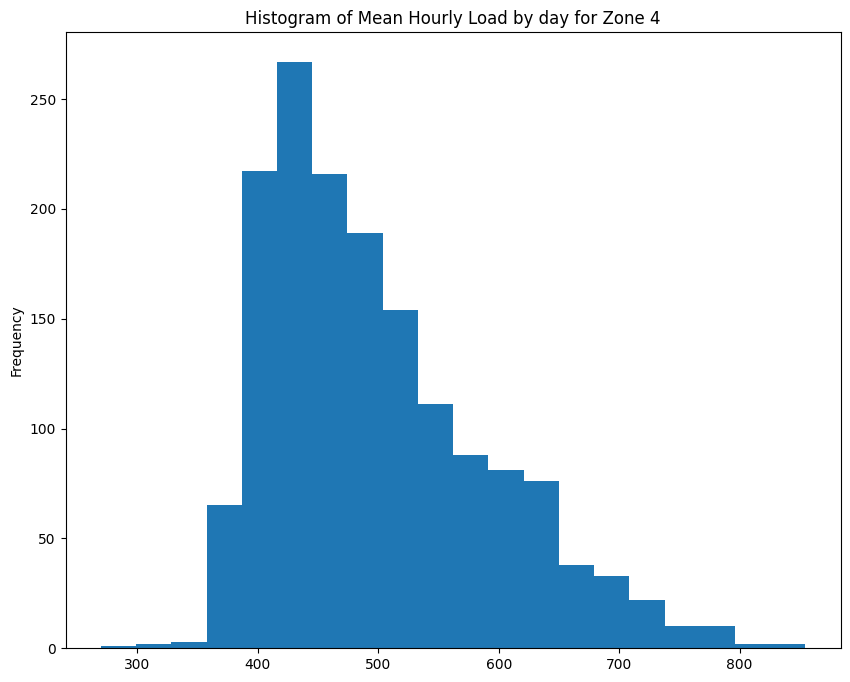

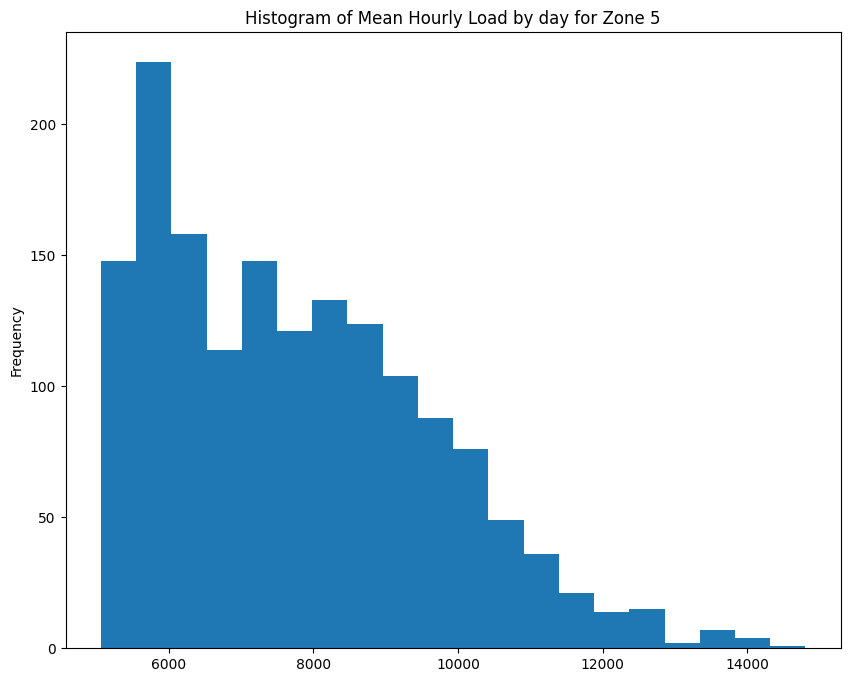

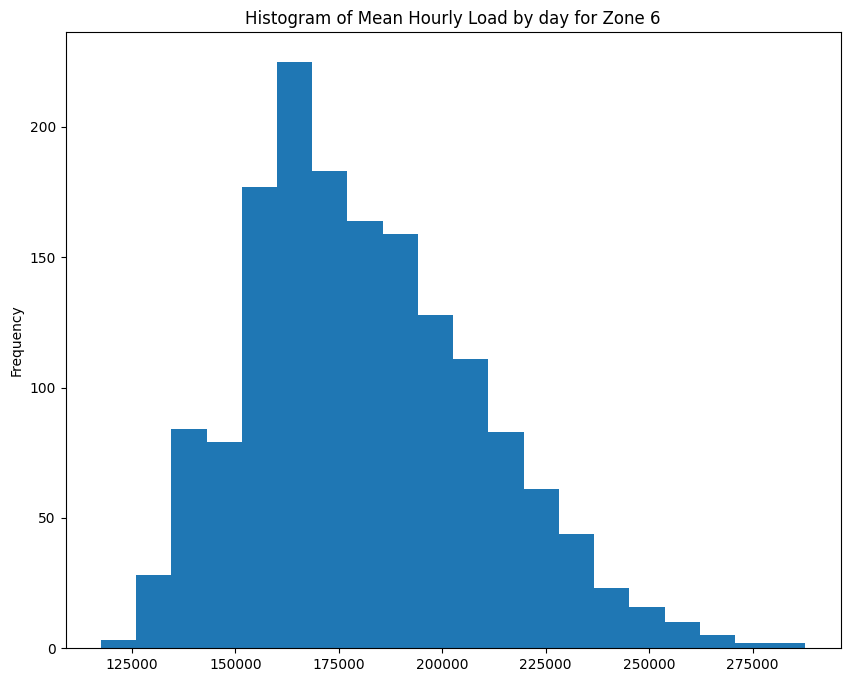

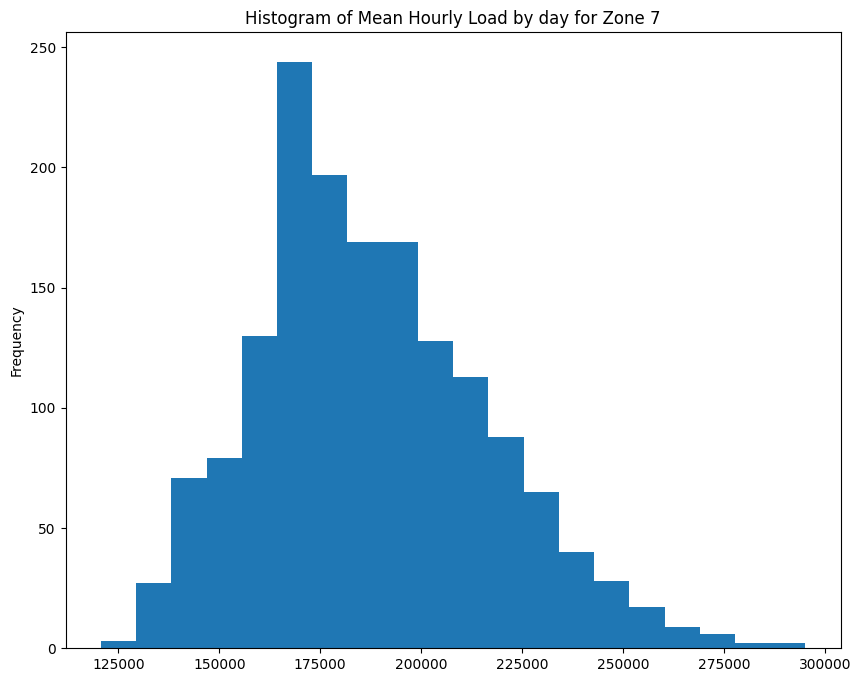

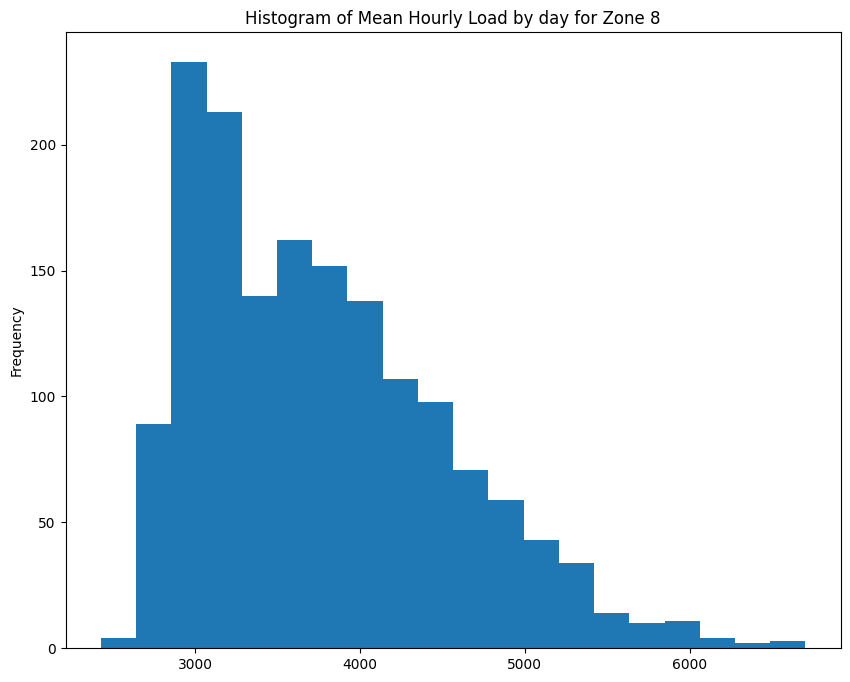

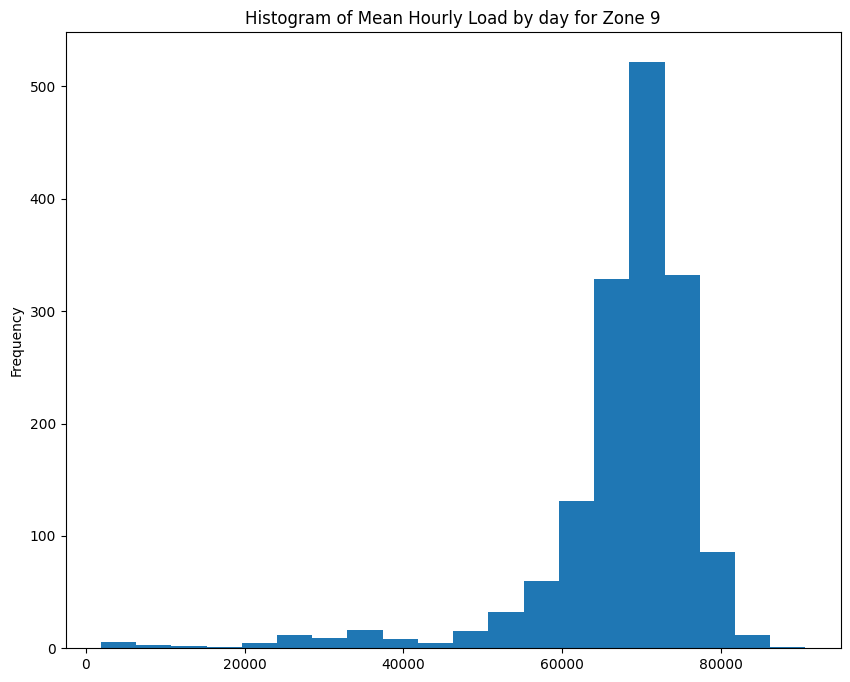

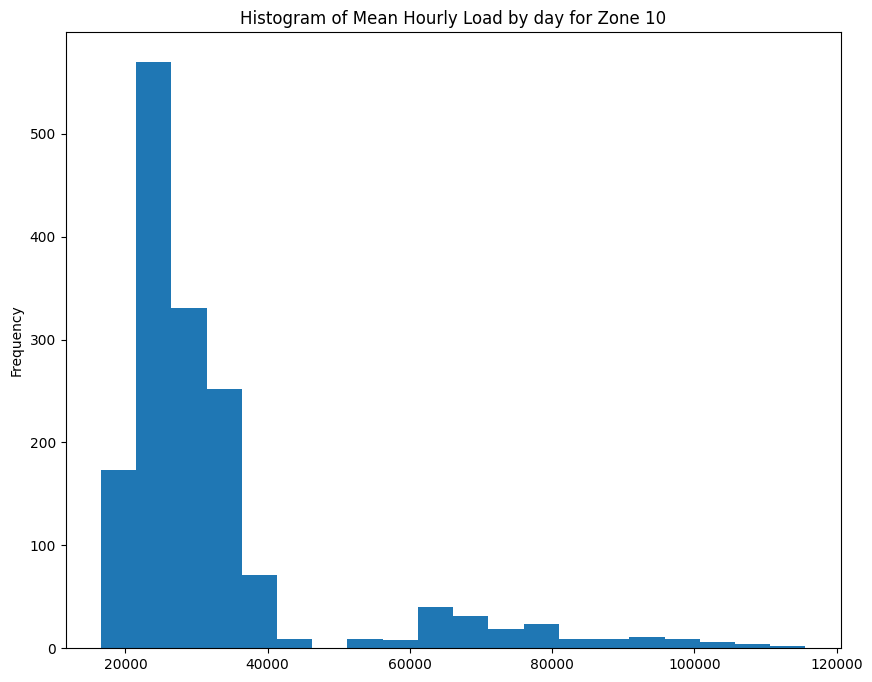

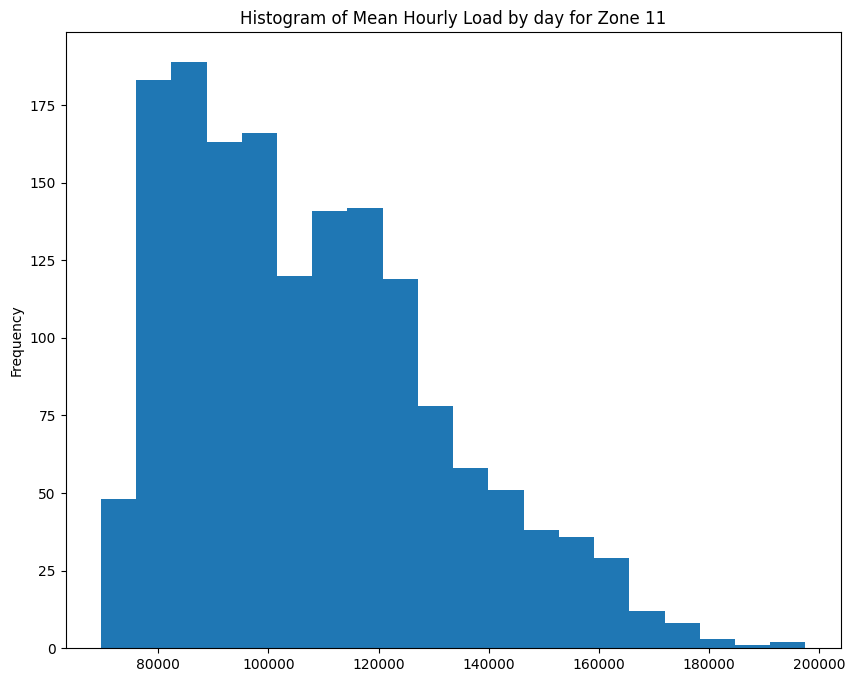

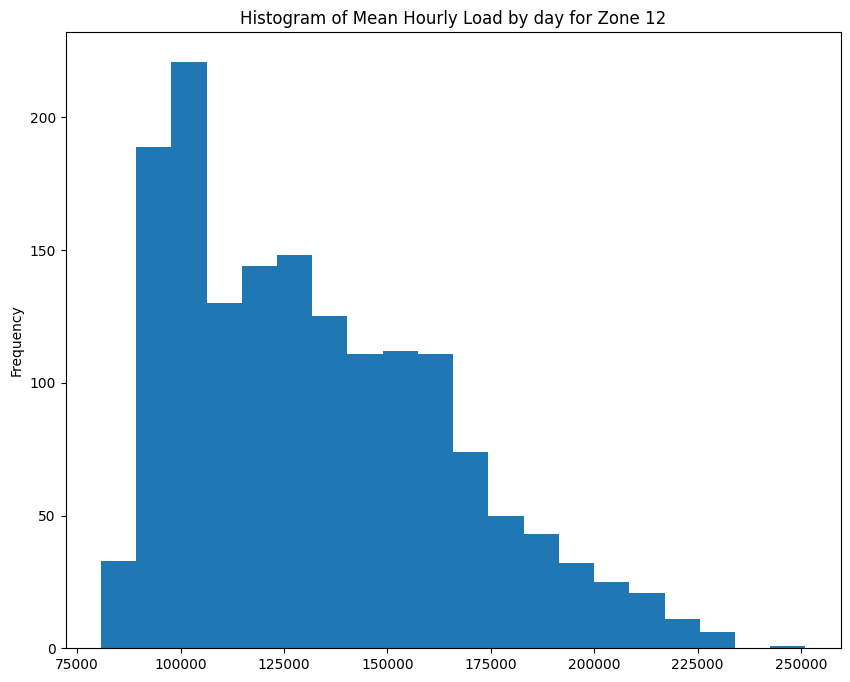

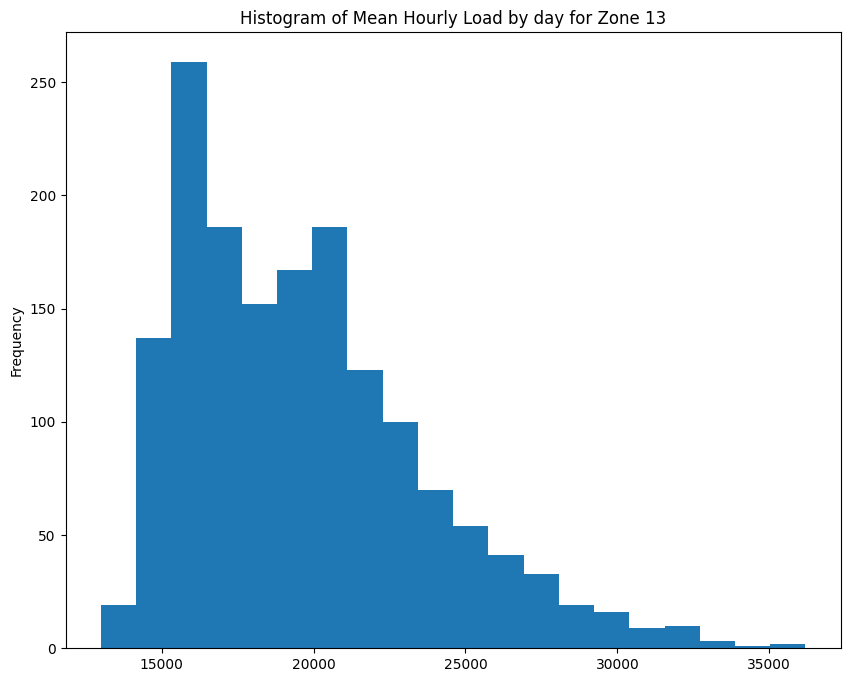

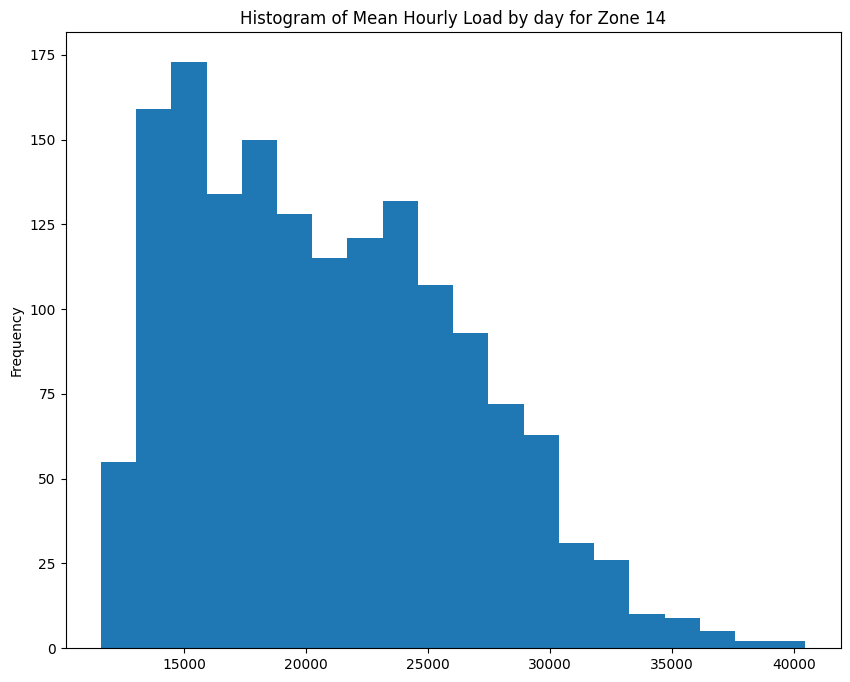

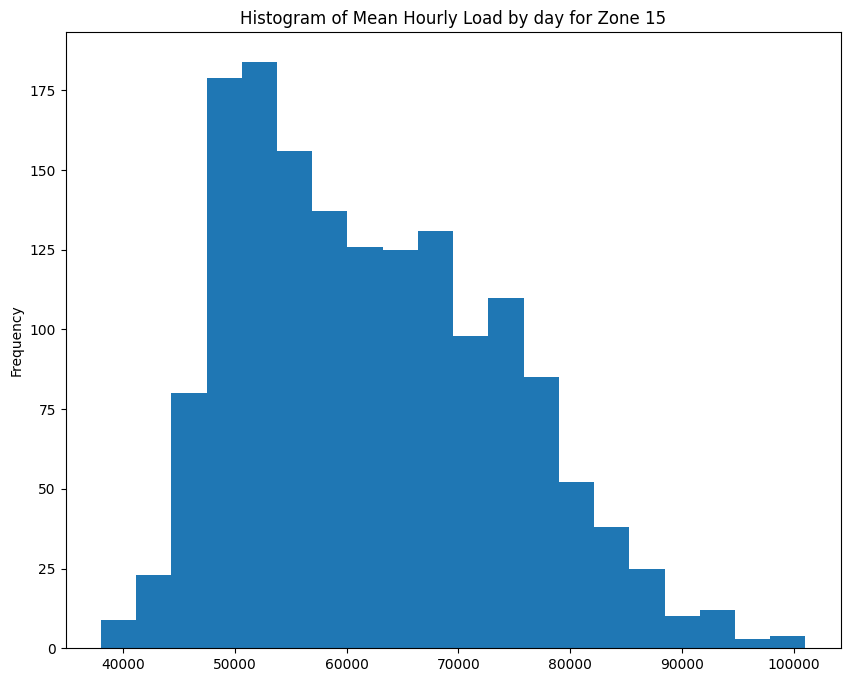

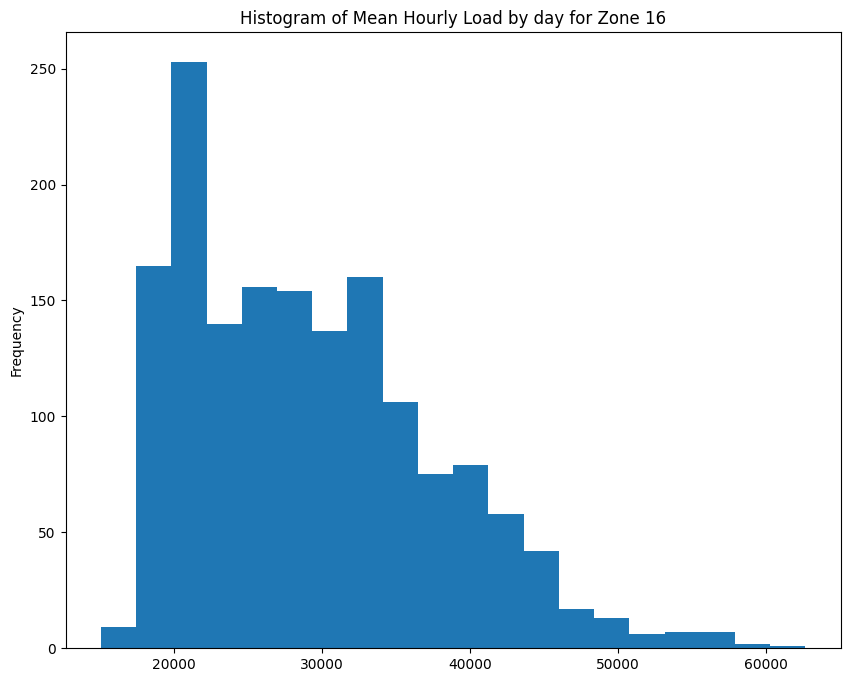

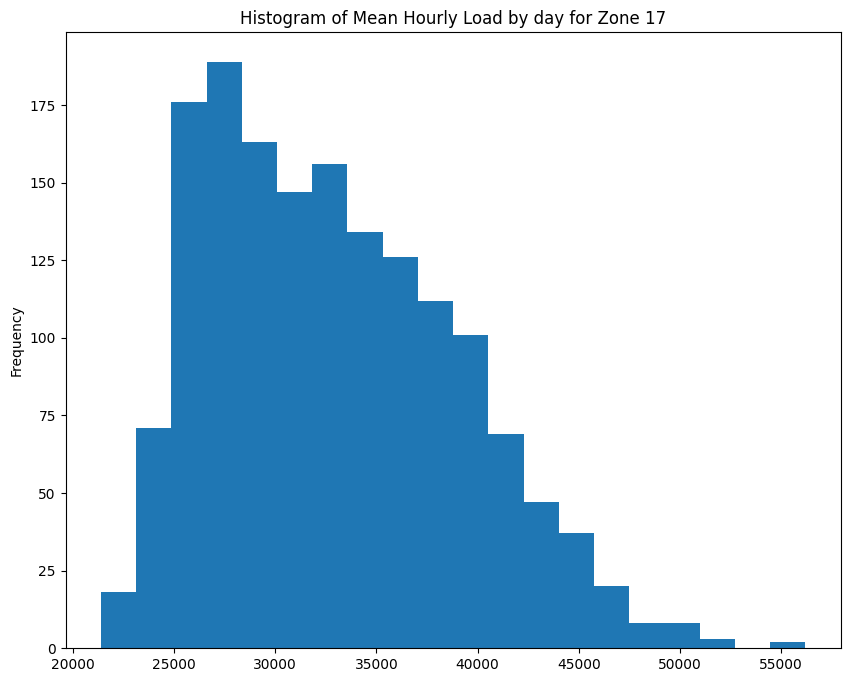

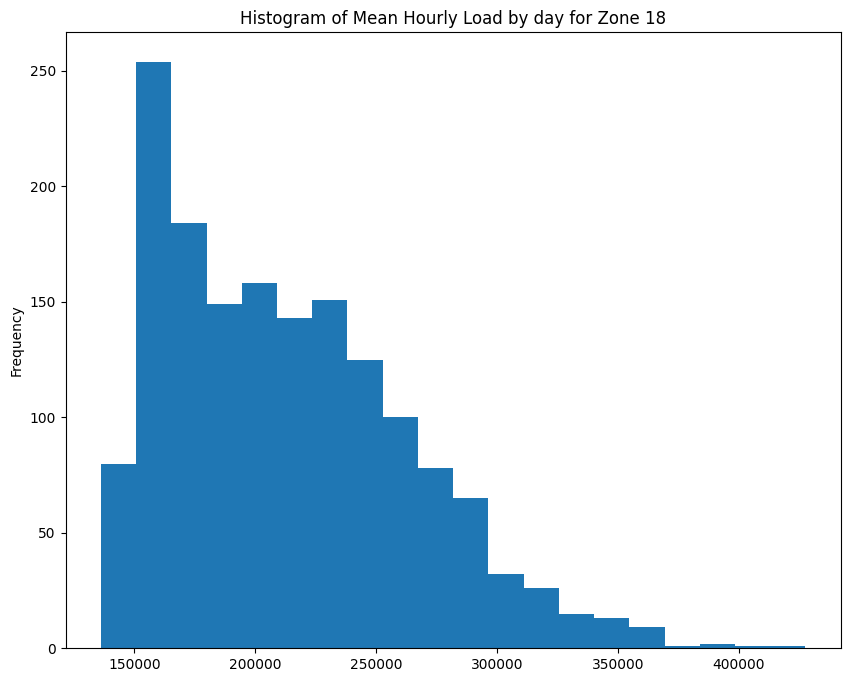

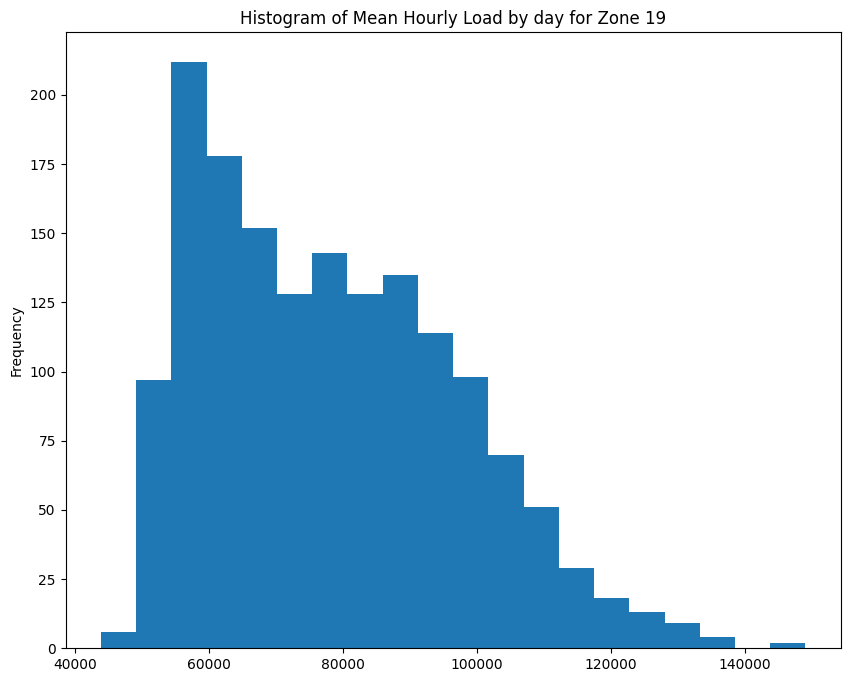

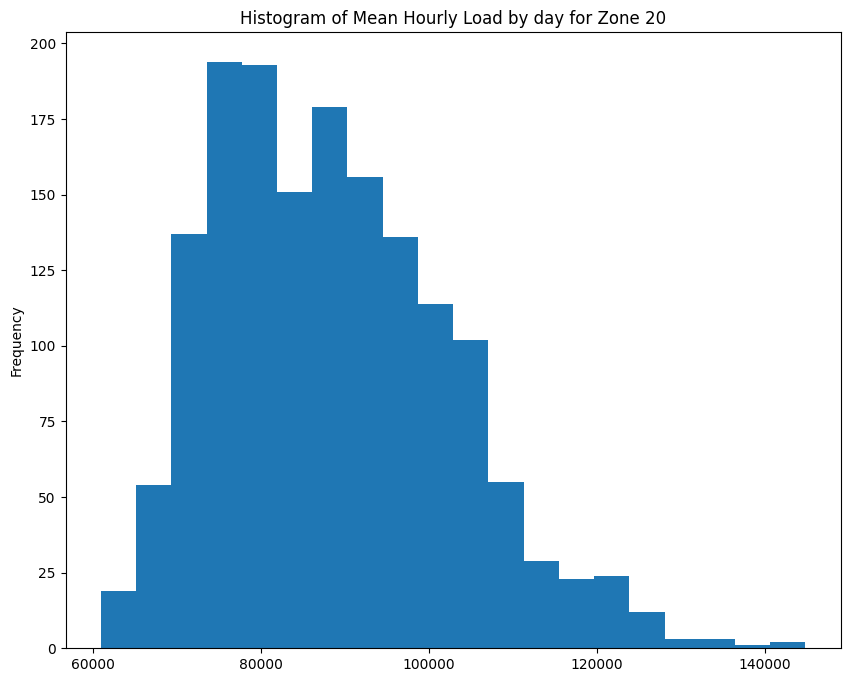

In [13]:
# make some histograms
for group in load_hist_g.groups:
    plt.figure(figsize=(10, 8))
    load_hist_g.get_group(group)['day_mean_load'].plot.hist(bins=20, title=f'Histogram of Mean Hourly Load by day for Zone {group}')
    plt.show()

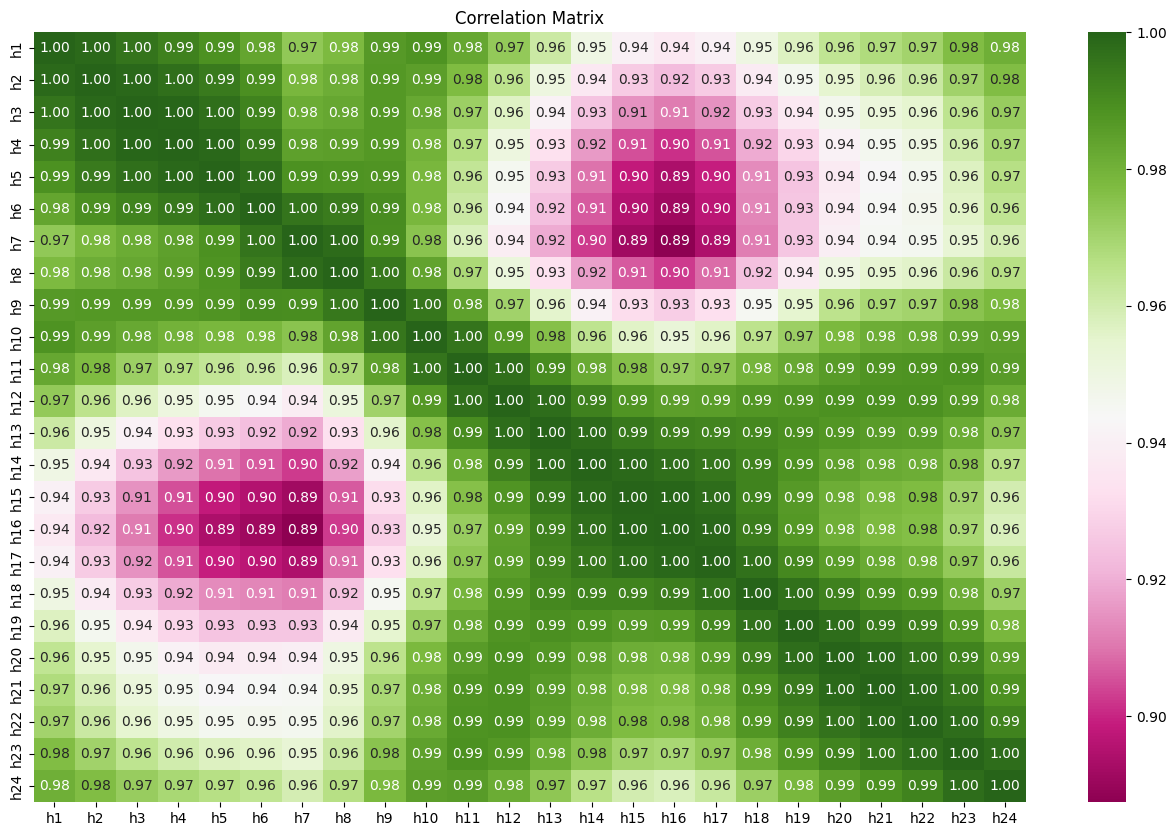

In [14]:
# Investigate correlations between hours
corr_mtx = load_hist.corr().iloc[2:-2, 2:-2]

plt.figure(figsize=(16, 10))
sns.heatmap(corr_mtx, annot=True, cmap="PiYG", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

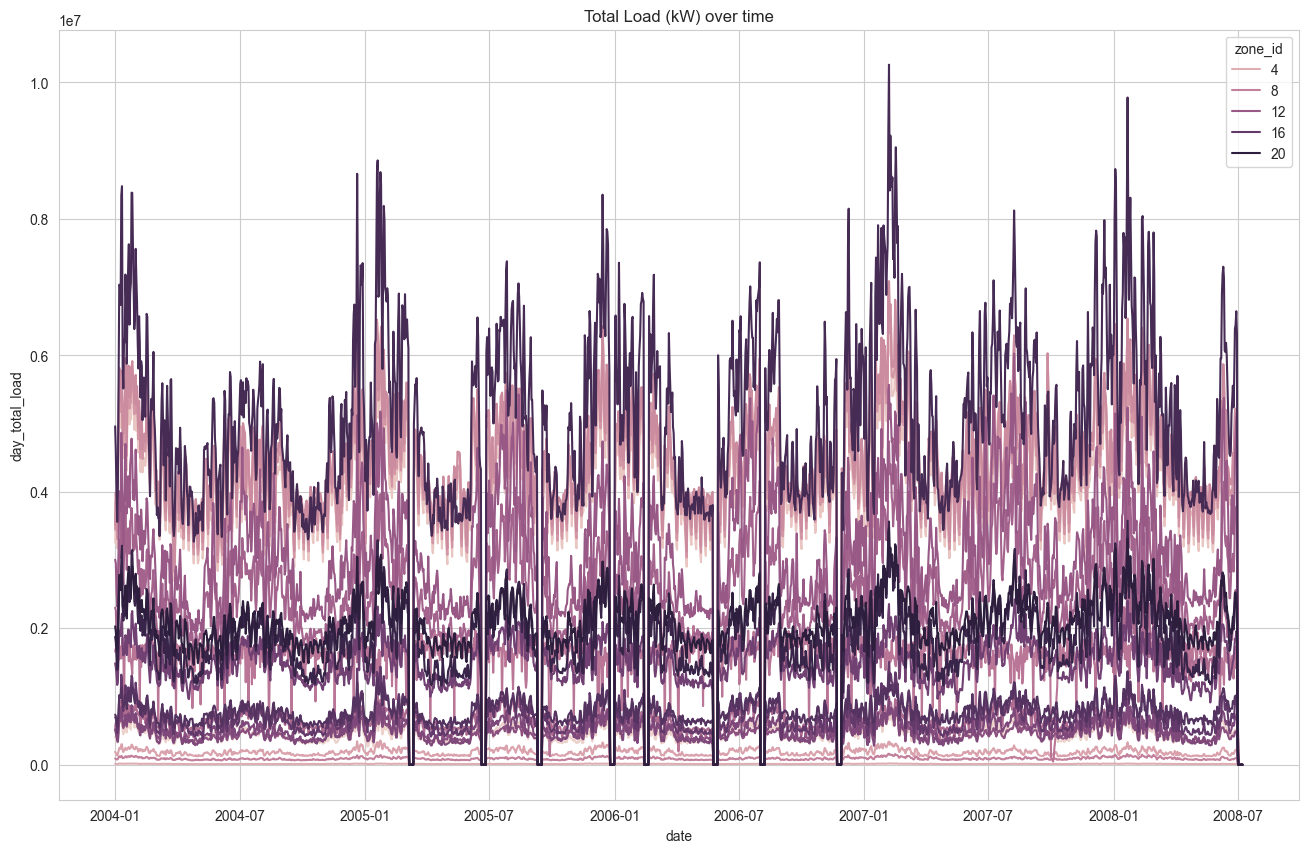

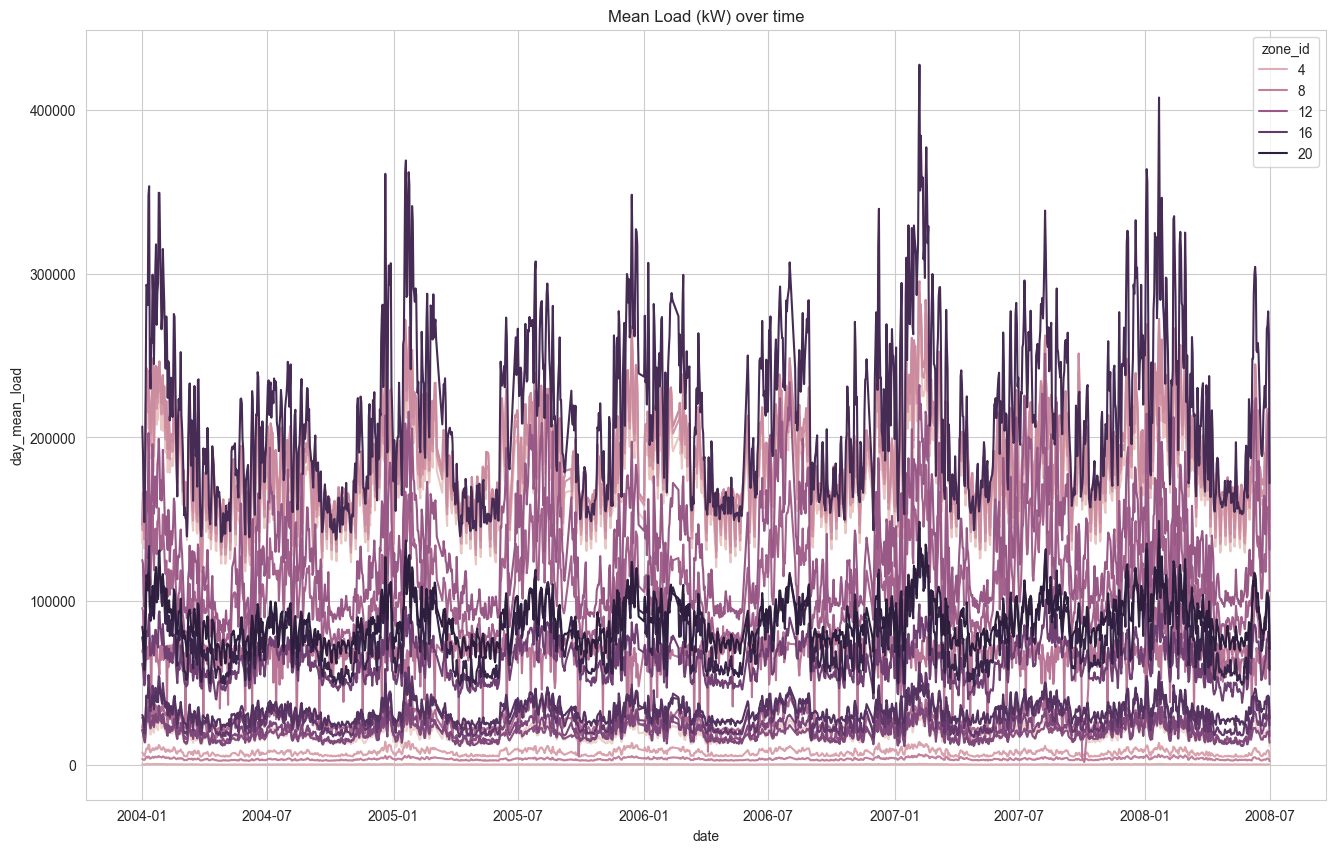

In [15]:
# Let's visualize trends over time!
sns.set_style("whitegrid")

plt.figure(figsize=(16, 10))
sns.lineplot(data=load_hist, x="date", y="day_total_load", hue="zone_id")
plt.title("Total Load (kW) over time")
plt.show()

plt.figure(figsize=(16, 10))
sns.lineplot(data=load_hist, x="date", y="day_mean_load", hue="zone_id")
plt.title("Mean Load (kW) over time")
plt.show()

## File 2: "temperature_history.csv"

### Step 1: preprocessing/cleaning

In [16]:
temperature_history_raw.columns

Index(['station_id', 'year', 'month', 'day', 'h1', 'h2', 'h3', 'h4', 'h5',
       'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16',
       'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23', 'h24'],
      dtype='object')

In [17]:
temperature_history_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18073 entries, 0 to 18072
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  18073 non-null  int64  
 1   year        18073 non-null  int64  
 2   month       18073 non-null  int64  
 3   day         18073 non-null  int64  
 4   h1          18073 non-null  int64  
 5   h2          18073 non-null  int64  
 6   h3          18073 non-null  int64  
 7   h4          18073 non-null  int64  
 8   h5          18073 non-null  int64  
 9   h6          18073 non-null  int64  
 10  h7          18062 non-null  float64
 11  h8          18062 non-null  float64
 12  h9          18062 non-null  float64
 13  h10         18062 non-null  float64
 14  h11         18062 non-null  float64
 15  h12         18062 non-null  float64
 16  h13         18062 non-null  float64
 17  h14         18062 non-null  float64
 18  h15         18062 non-null  float64
 19  h16         18062 non-nul

In [18]:
temp_hist = pd.DataFrame()

# station id can be taken over as-is
temp_hist['station_id'] = temperature_history_raw['station_id']

# convert date columns
temp_hist['date'] = pd.to_datetime(temperature_history_raw[['year', 'month', 'day']])

# bring in hour columns
for col in hour_cols:
    temp_hist[col] = temperature_history_raw[col].astype("float64")

# make summary columns
temp_hist['day_mean_temp'] = temp_hist[hour_cols].mean(axis=1)
temp_hist['day_max_temp'] = temp_hist[hour_cols].max(axis=1)
temp_hist['day_min_temp'] = temp_hist[hour_cols].min(axis=1)

# describe resulting df
temp_hist.describe()

,station_id,date,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24,day_mean_temp,day_max_temp,day_min_temp
count,18073.000000,18073,18073.000000,18073.000000,18073.000000,18073.000000,18073.000000,18073.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18073.000000,18073.000000,18073.000000
mean,6.000000,2006-04-01 00:00:00,52.826924,52.196979,51.643225,51.135451,50.681735,50.292702,50.392260,51.847968,54.570369,57.780589,60.468719,62.603532,64.202137,65.364411,66.076514,66.191452,65.648765,64.137914,61.622799,58.850072,56.660946,55.327317,54.342376,53.533994,57.438444,67.460964,47.751784
min,1.000000,2004-01-01 00:00:00,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,6.000000,9.000000,11.000000,13.000000,14.000000,16.000000,16.000000,17.000000,16.000000,14.000000,11.000000,9.000000,7.000000,5.000000,5.000000,11.666667,17.000000,0.000000
25%,3.000000,2005-02-14 00:00:00,40.000000,39.000000,39.000000,38.000000,38.000000,37.000000,37.000000,37.000000,40.000000,43.000000,46.000000,48.000000,50.000000,52.000000,52.000000,52.000000,52.000000,50.000000,47.000000,45.000000,44.000000,42.000000,41.000000,41.000000,44.250000,54.000000,34.000000
50%,6.000000,2006-04-01 00:00:00,54.000000,54.000000,53.000000,53.000000,52.000000,52.000000,52.000000,54.000000,56.000000,60.000000,62.000000,64.000000,66.000000,67.000000,68.000000,68.000000,68.000000,66.000000,63.000000,61.000000,58.000000,57.000000,56.000000,55.000000,58.833333,70.000000,48.000000
75%,9.000000,2007-05-17 00:00:00,66.000000,66.000000,65.000000,64.000000,64.000000,64.000000,64.000000,67.000000,70.000000,73.000000,76.000000,78.000000,80.000000,81.000000,81.000000,81.000000,80.000000,79.000000,77.000000,73.000000,71.000000,69.000000,68.000000,67.000000,71.541667,82.000000,62.000000
max,11.000000,2008-06-30 00:00:00,86.000000,85.000000,85.000000,85.000000,83.000000,82.000000,84.000000,87.000000,91.000000,96.000000,98.000000,100.000000,101.000000,103.000000,103.000000,104.000000,103.000000,102.000000,99.000000,97.000000,95.000000,91.000000,92.000000,88.000000,91.000000,104.000000,82.000000
std,3.162365,NaN,15.706729,15.693326,15.705607,15.711079,15.737625,15.774570,16.125607,17.095942,17.628109,17.594346,17.605722,17.625593,17.608548,17.551335,17.467881,17.318609,17.200823,17.311366,17.393181,16.769876,16.078702,15.858632,15.775466,15.742130,16.090062,17.077478,16.245925


In [19]:
# make a grouped variant
temp_hist_g = temp_hist.groupby('station_id')

# describe
temp_hist_g.describe()

date                                            \
           count                 mean                  min   
station_id                                                   
1           1643  2006-04-01 00:00:00  2004-01-01 00:00:00   
2           1643  2006-04-01 00:00:00  2004-01-01 00:00:00   
3           1643  2006-04-01 00:00:00  2004-01-01 00:00:00   
4           1643  2006-04-01 00:00:00  2004-01-01 00:00:00   
5           1643  2006-04-01 00:00:00  2004-01-01 00:00:00   
6           1643  2006-04-01 00:00:00  2004-01-01 00:00:00   
7           1643  2006-04-01 00:00:00  2004-01-01 00:00:00   
8           1643  2006-04-01 00:00:00  2004-01-01 00:00:00   
9           1643  2006-04-01 00:00:00  2004-01-01 00:00:00   
10          1643  2006-04-01 00:00:00  2004-01-01 00:00:00   
11          1643  2006-04-01 00:00:00  2004-01-01 00:00:00   

                                                                           \
                            25%                  50%                  75%   
station_id                                                                  
1           2005-02-14 12:00:00  2006-04-01 00:00:00  2007-05-16 12:00:00   
2           2005-02-14 12:00:00  2006-04-01 00:00:00  2007-05-16 12:00:00   
3           2005-02-14 12:00:00  2006-04-01 00:00:00  2007-05-16 12:00:00   
4           2005-02-14 12:00:00  2006-04-01 00:00:00  2007-05-16 12:00:00   
5           2005-02-14 12:00:00  2006-04-01 00:00:00  2007-05-16 12:00:00   
6           2005-02-14 12:00:00  2006-04-01 00:00:00  2007-05-16 12:00:00   
7           2005-02-14 12:00:00  2006-04-01 00:00:00  2007-05-16 12:00:00   
8           2005-02-14 12:00:00  2006-04-01 00:00:00  2007-05-16 12:00:00   
9           2005-02-14 12:00:00  2006-04-01 00:00:00  2007-05-16 12:00:00   
10          2005-02-14 12:00:00  2006-04-01 00:00:00  2007-05-16 12:00:00   
11          2005-02-14 12:00:00  2006-04-01 00:00:00  2007-05-16 12:00:00   

                                          h1                               \
                            max  std   count       mean   min   25%   50%   
station_id                                                                  
1           2008-06-30 00:00:00  NaN  1643.0  55.807669  16.0  44.0  57.0   
2           2008-06-30 00:00:00  NaN  1643.0  49.915399   5.0  37.0  52.0   
3           2008-06-30 00:00:00  NaN  1643.0  51.464394  10.0  38.0  52.0   
4           2008-06-30 00:00:00  NaN  1643.0  54.955569  14.0  42.0  56.0   
5           2008-06-30 00:00:00  NaN  1643.0  52.411442  12.0  40.0  54.0   
6           2008-06-30 00:00:00  NaN  1643.0  53.703591  11.0  41.0  55.0   
7           2008-06-30 00:00:00  NaN  1643.0  54.006086  11.0  41.0  56.0   
8           2008-06-30 00:00:00  NaN  1643.0  53.664029   7.0  40.0  55.0   
9           2008-06-30 00:00:00  NaN  1643.0  51.642727   9.0  38.0  53.0   
10          2008-06-30 00:00:00  NaN  1643.0  53.586123  10.0  41.0  55.0   
11          2008-06-30 00:00:00  NaN  1643.0  49.939136   3.0  37.0  51.0   

                                       h2                                     \
             75%   max        std   count       mean   min   25%   50%   75%   
station_id                                                                     
1           69.0  86.0  15.341449  1643.0  55.438831  16.0  43.0  57.0  68.0   
2           63.0  79.0  15.163005  1643.0  49.192331   4.0  37.0  50.0  62.0   
3           65.0  82.0  15.940982  1643.0  51.069385  10.0  38.0  52.0  65.0   
4           68.0  86.0  15.654027  1643.0  54.334145  13.0  42.0  56.0  68.0   
5           67.0  82.0  15.942800  1643.0  52.000000  11.0  39.0  53.0  66.0   
6           67.0  81.0  14.930424  1643.0  53.016433  11.0  40.5  54.0  66.0   
7           68.0  86.0  16.054830  1643.0  53.223372  11.0  40.0  55.0  67.0   
8           67.0  84.0  15.812554  1643.0  52.924528   8.0  40.0  55.0  66.0   
9           65.0  82.0  15.856222  1643.0  50.930615   7.0  37.0  52.0  65.0   
10          67.0  81.0  1

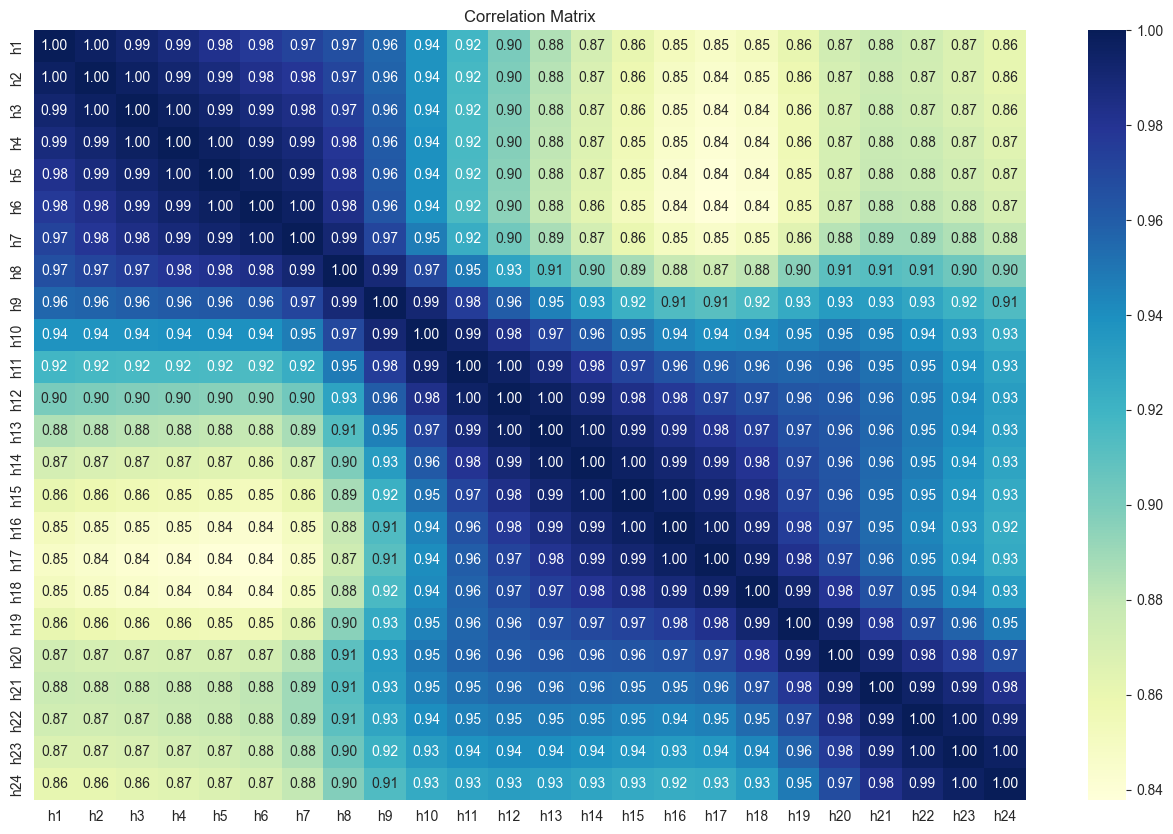

In [20]:
# Investigate correlations between hours
corr_mtx = temp_hist.corr().iloc[2:-3, 2:-3]

plt.figure(figsize=(16, 10))
sns.heatmap(corr_mtx, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Correlating stations and zones

In [23]:
# To do this, we need to see which stations have the highest correlation with each zone
hour_cols = [f"h{hour + 1}" for hour in range(24)]
map_cols = ["zone_id", "station_id", "total", "mean"] + hour_cols

mapping_mtx = pd.DataFrame(columns=map_cols)
for zone in load_hist_g.groups:
    print(f'Zone {zone}:')
    print(f"Zone group shape: {load_hist_g.get_group(zone).shape}")
    for station in temp_hist_g.groups:
        print(f'Station {station}:')
        print(f"Station group shape: {temp_hist_g.get_group(station).shape}")
        corrs = []
        for hour in hour_cols:
            val = load_hist_g.get_group(zone)[hour].corr(temp_hist_g.get_group(station)[hour])
            corrs.append(val)
            print (f'Zone: {zone} Station: {station} Hour: {hour} Corr: {val}')

Zone 1:
Zone group shape: (1650, 28)
Station 1:
Station group shape: (1643, 29)
Zone: 1 Station: 1 Hour: h1 Corr: -0.4526747274116394
Zone: 1 Station: 1 Hour: h2 Corr: -0.5635127567540541
Zone: 1 Station: 1 Hour: h3 Corr: -0.6393057990343536
Zone: 1 Station: 1 Hour: h4 Corr: -0.6901857115262903
Zone: 1 Station: 1 Hour: h5 Corr: -0.7267972212149454
Zone: 1 Station: 1 Hour: h6 Corr: -0.7590733431993512
Zone: 1 Station: 1 Hour: h7 Corr: -0.7846713222939421
Zone: 1 Station: 1 Hour: h8 Corr: -0.8046309136850495
Zone: 1 Station: 1 Hour: h9 Corr: -0.7406401185818381
Zone: 1 Station: 1 Hour: h10 Corr: -0.5441064558203256
Zone: 1 Station: 1 Hour: h11 Corr: -0.25171926212402157
Zone: 1 Station: 1 Hour: h12 Corr: 0.036577896467558185
Zone: 1 Station: 1 Hour: h13 Corr: 0.24776074693510977
Zone: 1 Station: 1 Hour: h14 Corr: 0.38402756250328035
Zone: 1 Station: 1 Hour: h15 Corr: 0.45528470348844424
Zone: 1 Station: 1 Hour: h16 Corr: 0.481715296228547
Zone: 1 Station: 1 Hour: h17 Corr: 0.461671785906